In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

from utils import common

In [ ]:
BASE_DATA_DIR = 'dzanga-bai-20210816T230919Z-001/dzanga-bai'

In [ ]:
def extract_indices(indices, seed, fold, num_indices):
    val_indices = indices[f'seed_{seed}_val_{fold}_indices']
    train_indices = []
    for i in range(5):
        if i == fold:
            continue
        train_indices.extend(indices[f'seed_{seed}_val_{i}_indices'])
    train_indices = np.array(train_indices)
    test_indices = np.array(list(set(range(num_indices)) - set(train_indices) - set(val_indices)))
    return train_indices, val_indices, test_indices

index_by_label = {'ad/sa': 0, 'inf/juv': 1}


def compute_class_accuracies(df):
    ad_sa_df = df[df['label'] == 0]
    ad_sa_accuracy = sklearn.metrics.accuracy_score(ad_sa_df['label'], ad_sa_df['predicted_label'], normalize=True)
    inf_juv_df = df[df['label'] == 1]
    inf_juv_accuracy = sklearn.metrics.accuracy_score(inf_juv_df['label'], inf_juv_df['predicted_label'], normalize=True)
    return ad_sa_accuracy, inf_juv_accuracy


def compute_f1_macro(df):
    return sklearn.metrics.f1_score(df['label'], df['predicted_label'], average='macro')


def compute_leakage_for_fold(run_name, indices, seed, fold):
    df = common.load_dz_data(BASE_DATA_DIR)
    train_indices, val_indices, test_indices = extract_indices(indices, seed, fold, len(df))
    # Had a typo in the name for this run.
    if run_name == 'with_leakage' and seed == 300:
        predictions_path = f'backups/extra_experiments/dz_predictions/{run_name}_{seed}_{seed}_{fold}_dz_predictions.npz'
    else:
        predictions_path = f'backups/extra_experiments/dz_predictions/{run_name}_seed_{seed}_{seed}_{fold}_dz_predictions.npz'
    predictions = np.load(predictions_path)['dz_predictions']
    label_predictions = np.argmax(predictions, axis=1)
    df['label'] = df['agecat'].apply(lambda label: index_by_label[label])
    df['predicted_label'] = label_predictions
    train = df.iloc[train_indices]
    train_rumble_ids = set(train['rumble_id'])
    df['leaked'] = df['rumble_id'].isin(train_rumble_ids)
    val = df.iloc[val_indices]
    test = df.iloc[test_indices]
    leaked_val_f1_macro = compute_f1_macro(val[val['leaked']])
    non_leaked_val_f1_macro = compute_f1_macro(val[~val['leaked']])
    leaked_test_f1_macro = compute_f1_macro(test[test['leaked']])
    non_leaked_test_f1_macro = compute_f1_macro(test[~test['leaked']])
    leaked_val_class_accuracies = compute_class_accuracies(val[val['leaked']])
    non_leaked_val_class_accuracies = compute_class_accuracies(val[~val['leaked']])
    leaked_test_class_accuracies = compute_class_accuracies(test[test['leaked']])
    non_leaked_test_class_accuracies = compute_class_accuracies(test[~test['leaked']])
    leakage_df = pd.DataFrame([[
        fold,
        leaked_val_f1_macro,
        non_leaked_val_f1_macro,
        leaked_test_f1_macro,
        non_leaked_test_f1_macro,
        leaked_val_class_accuracies[0],
        non_leaked_val_class_accuracies[0],
        leaked_test_class_accuracies[0],
        non_leaked_test_class_accuracies[0],
        leaked_val_class_accuracies[1],
        non_leaked_val_class_accuracies[1],
        leaked_test_class_accuracies[1],
        non_leaked_test_class_accuracies[1],
    ]], columns=[
        'Fold',
        'Leaked val f1 macro',
        'Non-leaked val f1 macro',
        'Leaked test f1 macro',
        'Non-leaked test f1 macro',
        'Leaked val ad/sa accuracy',
        'Non-leaked val ad/sa accuracy',
        'Leaked test ad/sa accuracy',
        'Non-leaked test ad/sa accuracy',
        'Leaked val inf/juv accuracy',
        'Non-leaked val inf/juv accuracy',
        'Leaked test inf/juv accuracy',
        'Non-leaked test inf/juv accuracy',
    ])
    return leakage_df

def compute_leakage_for_seed(run_name, seed):
    # Had a typo in the name for this run.
    if run_name == 'with_leakage' and seed == 300:
        indices_path = f'backups/extra_experiments/indices/{run_name}_{seed}_indices.npz'
    else:
        indices_path = f'backups/extra_experiments/indices/{run_name}_seed_{seed}_indices.npz'
    indices = np.load(indices_path)
    leakage_dfs = []
    for fold in range(5):
        leakage_dfs.append(compute_leakage_for_fold(run_name, indices, seed, fold))
    merged_df = pd.concat(leakage_dfs)
    merged_df['Seed'] = seed
    return merged_df

def compute_leakage(run_name):
    leakage_dfs = []
    for seed in (100, 200, 300):
        leakage_dfs.append(compute_leakage_for_seed(run_name, seed))
    merged_df = pd.concat(leakage_dfs)
    merged_df['Name'] = run_name
    return merged_df

In [ ]:
def plot_val_and_test(leakage_df, val_f1_macro_columns, test_f1_macro_columns, labels, title_suffix, bar_labels=False):
    seeds = sorted(leakage_df['Seed'].unique()) + ['Overall']
    
    df = leakage_df.drop(['Name'], axis=1)
    grouped_df = df.groupby(by='Seed')
    means = grouped_df.mean()
    errs = grouped_df.std()
    overall_means = df.mean()
    overall_errs = df.std()

    # Adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
    x = np.arange(len(seeds))  # the label locations
    width = 0.72 / len(val_f1_macro_columns)  # the width of the bars

    start_location = x - (len(val_f1_macro_columns) - 1) * width/2

    fig, ax = 01
    val_ax = ax[0]
    for i in range(len(val_f1_macro_columns)):
        rect = val_ax.bar(start_location + i * width, list(means[val_f1_macro_columns[i]]) + [overall_means[val_f1_macro_columns[i]]], width, label=labels[i], yerr=list(errs[val_f1_macro_columns[i]]) + [overall_errs[val_f1_macro_columns[i]]])
        if bar_labels:
            val_ax.bar_label(rect, padding=3, fmt='%0.3f')
    val_ax.set_xlabel('Seed')
    val_ax.set_ylabel('Val f1 macro')
    val_ax.set_title(f'Val f1 macro by seed and {title_suffix}')
    val_ax.set_xticks(x)
    val_ax.set_xticklabels(seeds)
    val_ax.legend(loc='lower left' if bar_labels else 'best')

    test_ax = ax[1]

    for i in range(len(test_f1_macro_columns)):
        rect = test_ax.bar(start_location + i * width, list(means[test_f1_macro_columns[i]]) + [overall_means[test_f1_macro_columns[i]]], width, label=labels[i], yerr=list(errs[test_f1_macro_columns[i]]) + [overall_errs[test_f1_macro_columns[i]]])
        if bar_labels:
            test_ax.bar_label(rect, padding=3, fmt='%0.3f')
    test_ax.set_xlabel('Seed')
    test_ax.set_ylabel('Test f1 macro')
    test_ax.set_title(f'Test f1 macro by seed and {title_suffix}')
    test_ax.set_xticks(x)
    test_ax.set_xticklabels(seeds)
    test_ax.legend(loc='lower left' if bar_labels else 'best')

    plt.show()


def plot_test_class_accuracies(leakage_df, ad_sa_columns, inf_juv_columns, labels, title_suffix, bar_labels=False):
    seeds = sorted(leakage_df['Seed'].unique()) + ['Overall']
    
    df = leakage_df.drop(['Name'], axis=1)
    grouped_df = df.groupby(by='Seed')
    means = grouped_df.mean()
    errs = grouped_df.std()
    overall_means = df.mean()
    overall_errs = df.std()
    
    # Adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
    x = np.arange(len(seeds))  # the label locations
    width = 0.72 / len(ad_sa_columns)  # the width of the bars

    start_location = x - (len(ad_sa_columns) - 1) * width/2

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ad_sa_ax = ax[0]
    for i in range(len(ad_sa_columns)):
        rect = ad_sa_ax.bar(start_location + i * width, list(means[ad_sa_columns[i]]) + [overall_means[ad_sa_columns[i]]], width, label=labels[i], yerr=list(errs[ad_sa_columns[i]]) + [overall_errs[ad_sa_columns[i]]])
        if bar_labels:
            ad_sa_ax.bar_label(rect, padding=3, fmt='%0.3f')
    ad_sa_ax.set_xlabel('Seed')
    ad_sa_ax.set_ylabel('ad/sa test accuracy')
    ad_sa_ax.set_title(f'ad/sa test accuracy by seed and {title_suffix}')
    ad_sa_ax.set_xticks(x)
    ad_sa_ax.set_xticklabels(seeds)
    ad_sa_ax.legend(loc='lower left' if bar_labels else 'best')

    inf_juv_ax = ax[1]

    for i in range(len(inf_juv_columns)):
        rect = inf_juv_ax.bar(start_location + i * width, list(means[inf_juv_columns[i]]) + [overall_means[inf_juv_columns[i]]], width, label=labels[i], yerr=list(errs[inf_juv_columns[i]]) + [overall_errs[inf_juv_columns[i]]])
        if bar_labels:
            inf_juv_ax.bar_label(rect, padding=3, fmt='%0.3f')
    inf_juv_ax.set_xlabel('Seed')
    inf_juv_ax.set_ylabel('inf/juv test accuracy')
    inf_juv_ax.set_title(f'inf/juv test accuracy by seed and {title_suffix}')
    inf_juv_ax.set_xticks(x)
    inf_juv_ax.set_xticklabels(seeds)
    inf_juv_ax.legend(loc='lower left' if bar_labels else 'best')

    plt.show()
    
    
def plot_f1_macro_and_class_accuracies(leakage_df, val_f1_macro_columns, test_f1_macro_columns, ad_sa_columns, inf_juv_columns, labels, title_suffix, bar_labels=False):
    plot_val_and_test(leakage_df, val_f1_macro_columns, test_f1_macro_columns, labels, title_suffix, bar_labels=bar_labels)
    plot_test_class_accuracies(leakage_df, ad_sa_columns, inf_juv_columns, labels, title_suffix, bar_labels=bar_labels)

In [ ]:
resnet101_fixed_spectrograms_leakage = compute_leakage('with_leakage_resnet_101_fixed_spectrograms')
resnet50_fixed_spectrograms_leakage = compute_leakage('with_leakage_resnet_50_fixed_spectrograms')
resnet101_original_spectrograms_leakage = compute_leakage('with_leakage_resnet_101_original_spectrograms')
resnet50_original_spectrograms_leakage = compute_leakage('with_leakage_resnet_50_original_spectrograms')

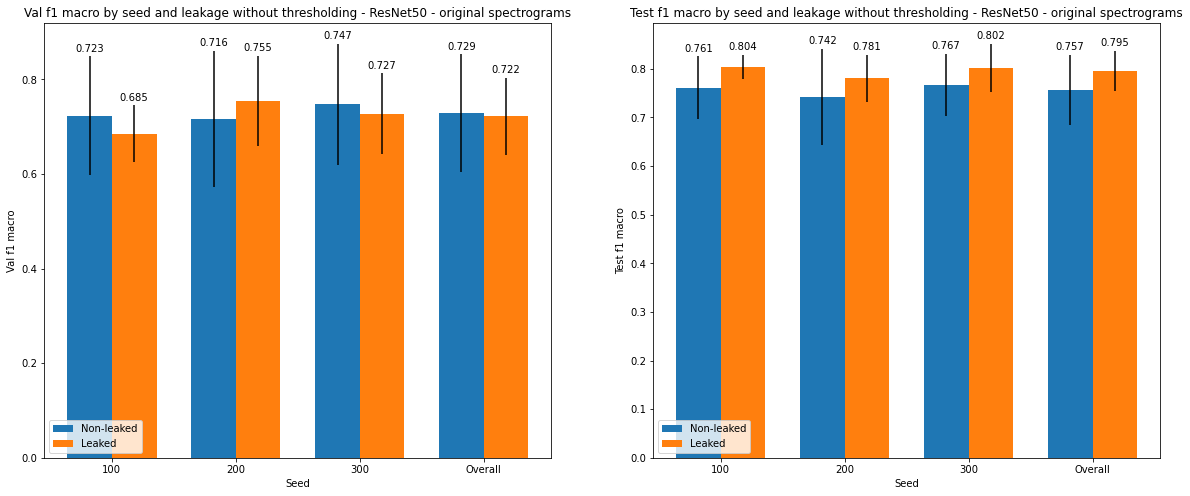

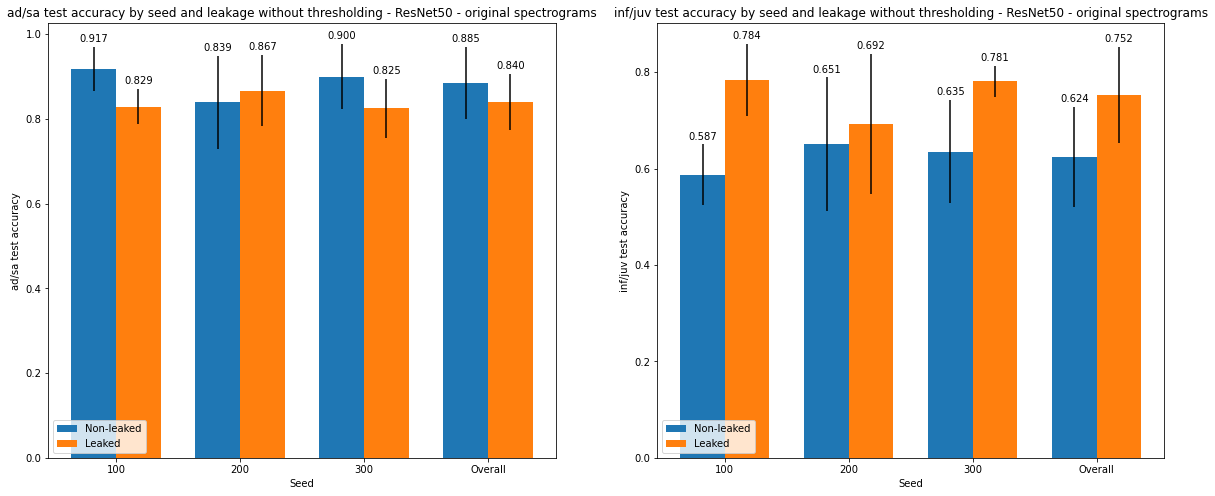

In [ ]:
plot_f1_macro_and_class_accuracies(
    resnet50_original_spectrograms_leakage,
    ['Non-leaked val f1 macro', 'Leaked val f1 macro'],
    ['Non-leaked test f1 macro', 'Leaked test f1 macro'],
    ['Non-leaked test ad/sa accuracy', 'Leaked test ad/sa accuracy'],
    ['Non-leaked test inf/juv accuracy', 'Leaked test inf/juv accuracy'],
    ['Non-leaked', 'Leaked'],
    'leakage without thresholding - ResNet50 - original spectrograms',
    bar_labels=True
)

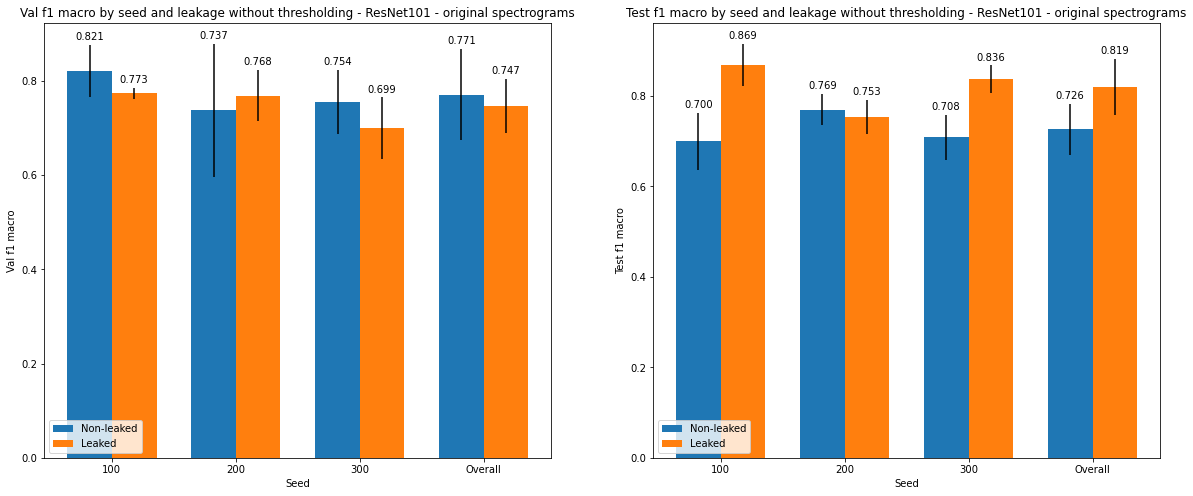

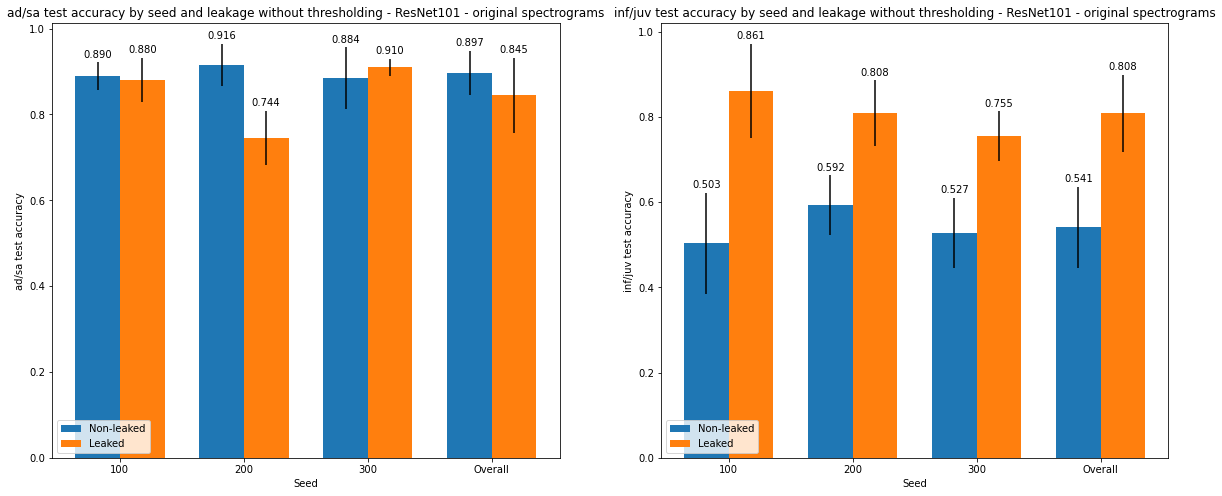

In [ ]:
plot_f1_macro_and_class_accuracies(
    resnet101_original_spectrograms_leakage,
    ['Non-leaked val f1 macro', 'Leaked val f1 macro'],
    ['Non-leaked test f1 macro', 'Leaked test f1 macro'],
    ['Non-leaked test ad/sa accuracy', 'Leaked test ad/sa accuracy'],
    ['Non-leaked test inf/juv accuracy', 'Leaked test inf/juv accuracy'],
    ['Non-leaked', 'Leaked'],
    'leakage without thresholding - ResNet101 - original spectrograms',
    bar_labels=True
)